In [1]:
import numpy as np
import pandas as pd

from plotnine import *
from sklearn.metrics import precision_recall_curve

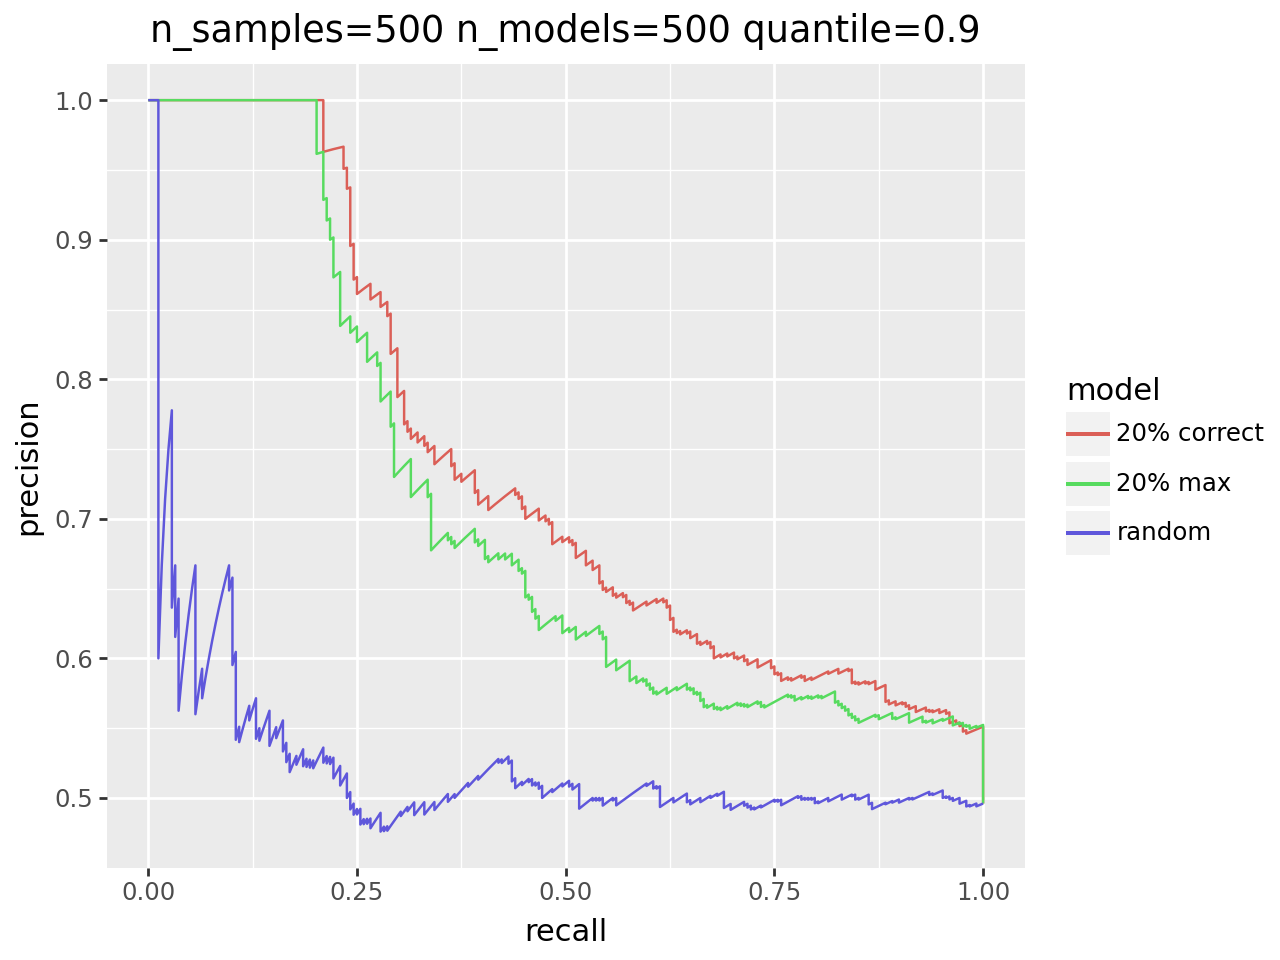

In [2]:
n_models = 500
n_samples = 500
n_rigged = n_samples // 10
quantile = 0.9
# E y = (1/10 * 1) + (1/10 * 0) + (8/10 E y|y~Bin(1, 0.5)) = 0.1 + 0.0 + 0.4 = 0.5
y = np.hstack((np.zeros(n_rigged), np.ones(n_rigged), np.random.binomial(n=1, p=0.5, size=n_rigged * 8)))


def curve(y_true, name, score_f):
    y_score_q = np.quantile([score_f() for _ in range(n_models)], quantile, axis=0)
    prec, rec, _ = precision_recall_curve(y_true, y_score_q)
    names = np.repeat(name, prec.shape[0])
    return pd.DataFrame({'precision': prec, 'recall': rec, 'model': names})
    

u = np.random.uniform
null = lambda: u(size=n_samples) # random
null_20 = lambda: np.hstack((u(0., 0.5, size=n_rigged), u(0.5 + 1e-6, 1., size=n_rigged), u(size=n_rigged * 8))) # 0.2 correct
null_20_max = lambda: np.hstack((np.zeros(n_rigged), np.ones(n_rigged), u(size=n_rigged * 8))) # 0.2 max

df_null = curve(y, name='random', score_f=null)
df_null_20 = curve(y, name='20% correct', score_f=null_20)
df_null_20_max = curve(y, name='20% max', score_f=null_20_max)

g = ggplot(data=pd.concat((df_null, df_null_20, df_null_20_max)))
g = g + aes('recall', 'precision', color='model')
g = g + labs(title=f"n_samples={n_samples} n_models={n_models} quantile={quantile}")
g = g + geom_path()
g